In [30]:
from IPython.display import display
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans


MAX_ITERATIONS = 24
MIN_DELTA_MU = 1

In [32]:
def k_means(data, K):
    # occasionally images will have NaN/inf in data
    data = np.nan_to_num(data)
    
    # randomly choose k centroids from the data points
    centroids = data[np.random.choice(len(data), size=K, replace=False)]
    deltas = []
    labels = None

    for i in range(MAX_ITERATIONS):
        # assign each data point to closest centroid
        distances = euclidean_distances(data, centroids)
        labels = np.array([np.argmin(i) for i in distances])

        # keep track of the largest difference in centroid means
        max_delta_mu = 0

        for k in range(K):
            # get all data points with label of this centroid k
            cluster_points = data[labels == k]
            if len(cluster_points) == 0:
                continue

            # get mean r, g, and b values of all points in this class
            # e.g. mu = [112.5, 95.6, 204.2]
            mu = cluster_points.mean(axis=0)

            # get the max difference in a r,g, or b value
            # abs(centroids[k] - mu) will return diff in RGB values
            # e.g. abs(centroids[k] - mu) = [15.2, 25.4, 4.7]
            delta_mu = abs(centroids[k] - mu).max()

            # keep track of largest difference in centroid means
            max_delta_mu = max(max_delta_mu, delta_mu)

            # update the kth centroid to the new mean value
            centroids[k] = mu
            
        deltas.append(max_delta_mu)

        # if the largest change in any centroid RGB color is less than 1, we can stop
        if max_delta_mu < MIN_DELTA_MU:
            print(f"reached delta_mu {max_delta_mu:.2f} < {MIN_DELTA_MU} in {i} iterations for K={K}")
            break

    # reassign each point to nearest centroid one last time
    distances = euclidean_distances(data, centroids)
    labels = np.array([np.argmin(i) for i in distances])

    return centroids, labels, deltas

In [21]:
def reduce_image(img, n_colors):
    """
    Apply K-means clustering to the given image (ndarray) with
    K=n_colors. Return the ndarray representing the reduced image.
    """
    # d (depth) will always be 3 due to RGB values
    w, h, d = img.shape

    # convert the image into a 2D array, where pixels[0] gets [r,g,b]
    # for the top-left and pixels[w*h] gets [r,g,b] for bottom-right
    pixels = np.float32(img.reshape((-1, d)))

    # perform k-means clustering on all pixels
    centroids, labels, deltas = k_means(data=pixels, K=n_colors)

    # update each pixel in the original image with its new classification
    pixels = np.array([centroids[i] for i in labels])

    # convert the 2D array back to 3D so it can be understood by skimage/plt
    # pixels[0][0] gets [r,g,b] at top-left, pixels[w][h] gets [r,g,b] at bottom-right
    pixels = np.int32(pixels.reshape((w, h, d)))

    return pixels, deltas, labels

In [43]:
def plot_image_comparison(name, img_arr):
    """
    Plot a 2x2 image comparison with the given array of images.
    img_arr is a list of tuples with format (img, title) where
    img is an ndarray and title is a str.
    """

    if len(img_arr) != 4:
        raise ValueError('img array must be of len 4')

    plt.clf()
    fig = plt.figure(figsize=(7, 7))
    rows, columns = (2, 2)

    for i, vals in enumerate(img_arr):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(vals["img"], vmin=0, vmax=255)
        plt.axis("off")
        plt.title(vals["title"])

    plt.savefig(f"{name}/comparison.jpeg")


def plot_centroid_movement(name, mu_arr):
    """
    Plot a line graph showing centroid movement. mu_arr is a list
    of tuples with format (mu_vals, title, color).
    """
    plt.clf()

    for vals in mu_arr:
        x, y = list(range(len(vals["mu"]))), vals["mu"]
        plt.plot(x, y, color=vals["color"], label=vals["label"])

    plt.title("Centroid Movement Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("Max Change")
    plt.legend(loc="upper right")
    plt.savefig(f"{name}/centroid_convergence.jpeg")


def plot_cluster_distributions(name, dist_arr):
    """
    Plot a histogram showing cluster distributions. dist_arr is a
    list of tuples with format (labels, title, xticks).
    """
    plt.clf()

    # create subplots with 1 row and len(dist_arr) columns
    fig, axs = plt.subplots(1, len(dist_arr), sharey=True)
    fig.suptitle("Cluster Distributions")
    fig.text(0.04, 0.5, 'Relative Cluster Size',
             va='center', rotation='vertical')

    for i, vals in enumerate(dist_arr):
        dist, title, xticks = vals["dist"], vals["title"], vals["xticks"]

        # go from [0...n] to [1...n+1]
        dist = dist + 1

        # set weights so sum of all bins adds to 100
        weights = 100 * np.ones_like(dist) / dist.size

        # plot the histogram
        axs[i].hist(dist, weights=weights, edgecolor="black")
        axs[i].set_xticks(xticks)
        axs[i].set_title(title, y=-0.01, pad=-26)

    plt.savefig(f"{name}/cluster_distributions.jpeg")


start K-means on baboon for K=[1, 4, 16]
reached delta_mu 0.00 < 1 in 1 iterations for K=1


C:\Users\Joey\AppData\Local\Temp/ipykernel_6656/490256604.py:23: UserWarning: baboon/1.jpeg is a low contrast image
  io.imsave(f"{basename}/{K}.jpeg", np.uint8(img_K))


reached delta_mu 0.90 < 1 in 8 iterations for K=4


<Figure size 432x288 with 0 Axes>

<Figure size 504x504 with 0 Axes>

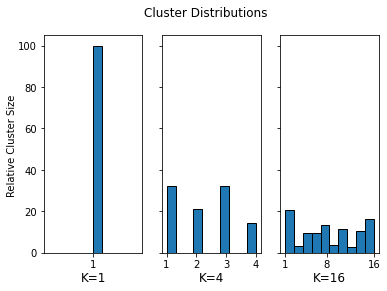

In [46]:
def perform_comparison(filename, k_values):
    """
    Compare the given image file with a 2x2 figure for the
    original image and the K=4, K=16, and K=32 images
    """
    basename = filename.split(".")[0]

    K_nums = [str(val["K"]) for val in k_values]
    print(f"\nstart K-means on {basename} for K=[{', '.join(K_nums)}]")

    if not os.path.exists(basename):
        os.mkdir(basename)

    img = io.imread(filename)
    comparisons = [{"img": img, "title": "Original Image"}]
    centroid_movements = []
    cluster_distributions = []

    for vals in k_values:
        K, color, xticks = vals["K"], vals["color"], vals["xticks"]

        img_K, mu_K, labels_K = reduce_image(img, n_colors=K)
        io.imsave(f"{basename}/{K}.jpeg", np.uint8(img_K))
        
        comparisons.append({"img": img_K, "title": f"Image Obtained for K={K}"})
        centroid_movements.append({"mu": mu_K, "label": f"K={K}", "color": color})
        cluster_distributions.append({"dist": labels_K, "title": f"K={K}", "xticks": xticks})

    plot_image_comparison(basename, comparisons)
    plot_centroid_movement(basename, centroid_movements)
    plot_cluster_distributions(basename, cluster_distributions)


k_values = [
    {"K": 4, "color": "blue", "xticks": [1,2,3,4]},
    {"K": 16, "color": "red", "xticks": [1,8,16]},
    {"K": 32, "color": "green", "xticks": [1,8,16,32]}
]

perform_comparison("baboon.jpeg", k_values)
# perform_comparison("rocket.jpeg", k_values)
# perform_comparison("smokey.jpeg", k_values)
# perform_comparison("truck.jpeg", k_values)
